In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import tqdm

import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

# Данные

In [3]:
df = pd.read_parquet('/Users/anastasts/Мой диск/Магистратура МИЭМ/1. Диплом/Подготовленные_данные/all_data.parquet', 
                  index=False, engine='fastparquet')

In [4]:
df

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,fclose_flag_1,pre_loans5_11,pre_loans3060_6,pre_since_confirmed_15,pre_loans3060_4,pre_loans6090_0,pre_loans3060_3,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,flag
0,0,0,1,1,1,1,2,0,1,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,1,0,0,0,0,1,2,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,1,0,0,0,0,0,0,0,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0,3,1,0,2,1,3,0,0,...,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0,0,0,0,0,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,1,2,0,0,2,0,1,0,0,...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999996,2999996,0,1,0,1,1,5,0,0,1,...,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999997,2999997,0,0,1,1,3,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2999998,2999998,0,0,0,0,1,0,0,1,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# XGBClassifier

Разделим выборку на test и train

In [5]:
def split(data):
    X = data.drop('flag', axis=1)
    y = data['flag']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = split(df)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100000, 420), (900000, 420), (2100000,), (900000,))

In [5]:
X = df.drop('flag', axis=1)
y = df['flag']

## Baseline

In [8]:
model_xgboost = xgb.XGBClassifier(
    n_estimators=10, 
    max_depth=6, 
    reg_lambda=0, 
    learning_rate=0.1,
    eval_metric='auc'
)

In [9]:
model_xgboost.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)

[0]	validation_0-auc:0.68630
[1]	validation_0-auc:0.69165
[2]	validation_0-auc:0.69740
[3]	validation_0-auc:0.70535
[4]	validation_0-auc:0.70781
[5]	validation_0-auc:0.71012
[6]	validation_0-auc:0.71384
[7]	validation_0-auc:0.71456
[8]	validation_0-auc:0.71583
[9]	validation_0-auc:0.71780


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [11]:
print('Model params: ')
print(model_xgboost.get_params())

Model params: 
{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': 0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [13]:
model_xgboost.evals_result()['validation_0']['auc']

[0.6862981482950058,
 0.6916545351470208,
 0.6973956444164673,
 0.7053504787136938,
 0.7078089427778235,
 0.7101233535935569,
 0.7138383779625574,
 0.714560263748586,
 0.715828572343502,
 0.7177968584432389]

In [15]:
df_score_xgb = pd.DataFrame()

df_score_xgb['iter'] = [i for i in range(0, len(model_xgboost.evals_result()['validation_0']['auc']))]
df_score_xgb['score'] = model_xgboost.evals_result()['validation_0']['auc']

In [16]:
df_score_xgb.head()

,iter,score
0,0,0.686298
1,1,0.691655
2,2,0.697396
3,3,0.705350
4,4,0.707809


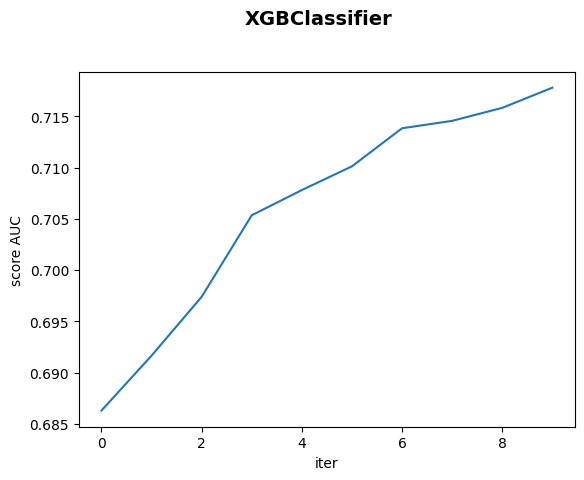

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)

# Set titles for the figure and the subplot respectively
fig.suptitle('XGBClassifier', fontsize=14, fontweight='bold')

ax.set_xlabel('iter')
ax.set_ylabel('score AUC')

ax.plot(df_score_xgb['iter'], df_score_xgb['score'])

### Feature Importance

<Axes: >

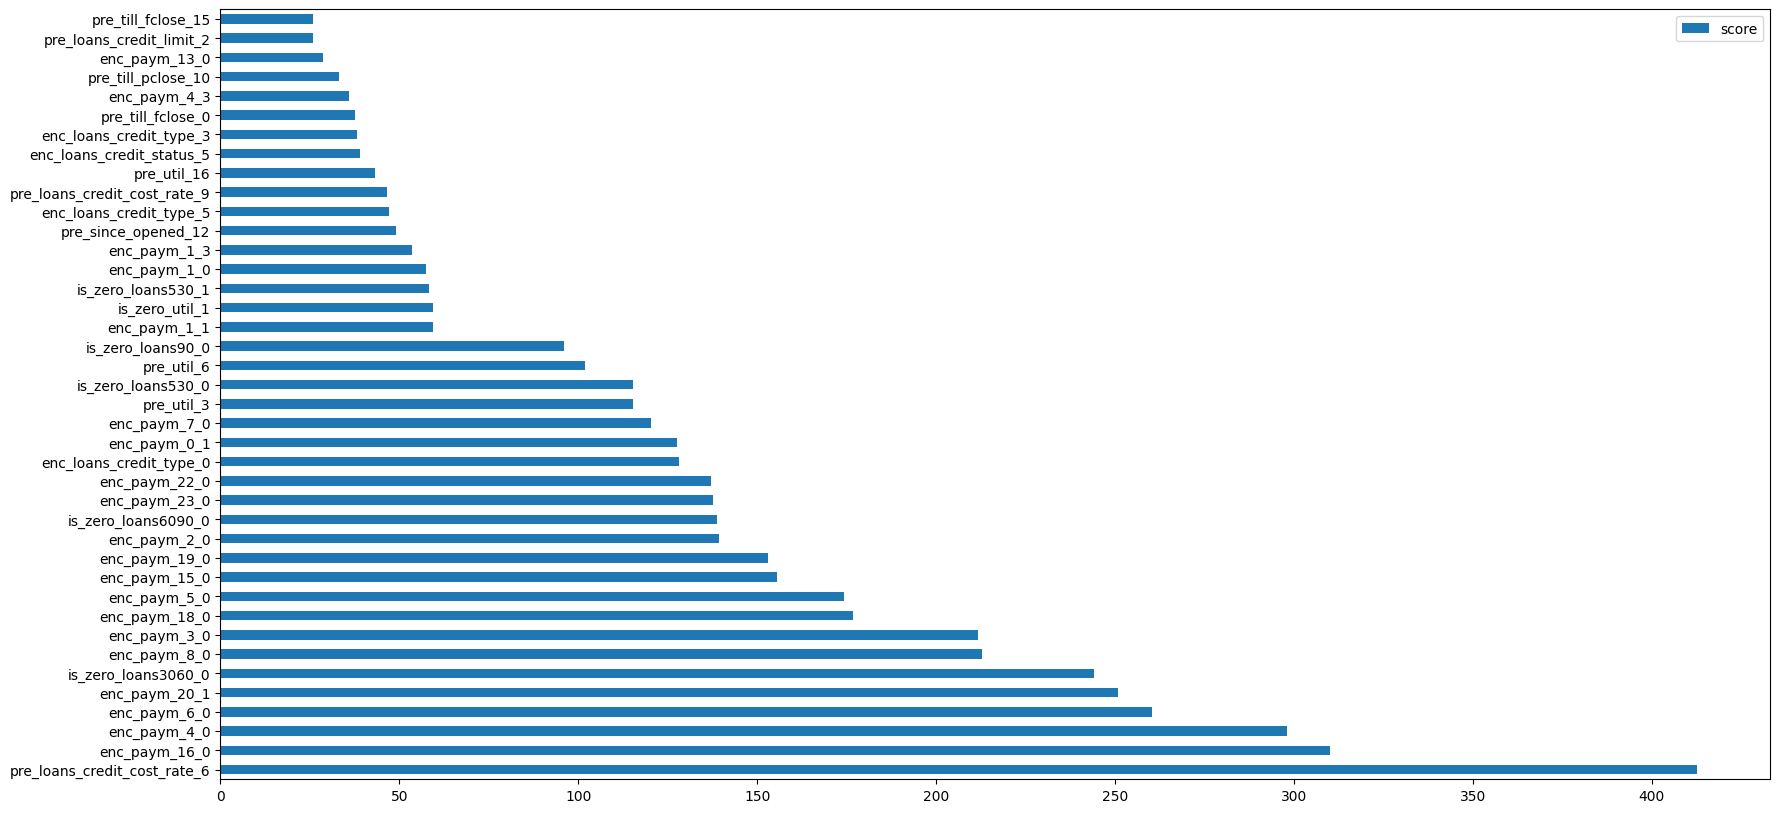

In [10]:
feature_important = model_xgboost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [12]:
keys

['id',
 'pre_since_opened_3',
 'pre_since_opened_6',
 'pre_since_opened_7',
 'pre_since_opened_9',
 'pre_since_opened_12',
 'pre_since_opened_13',
 'pre_since_opened_19',
 'pre_since_confirmed_0',
 'pre_since_confirmed_1',
 'pre_since_confirmed_2',
 'pre_since_confirmed_9',
 'pre_since_confirmed_10',
 'pre_pterm_3',
 'pre_pterm_6',
 'pre_pterm_12',
 'pre_pterm_17',
 'pre_fterm_0',
 'pre_fterm_3',
 'pre_fterm_7',
 'pre_fterm_11',
 'pre_fterm_14',
 'pre_fterm_15',
 'pre_fterm_16',
 'pre_till_pclose_1',
 'pre_till_pclose_2',
 'pre_till_pclose_5',
 'pre_till_pclose_10',
 'pre_till_pclose_11',
 'pre_till_pclose_15',
 'pre_till_pclose_16',
 'pre_till_fclose_0',
 'pre_till_fclose_2',
 'pre_till_fclose_3',
 'pre_till_fclose_4',
 'pre_till_fclose_6',
 'pre_till_fclose_14',
 'pre_till_fclose_15',
 'pre_loans_credit_limit_2',
 'pre_loans_credit_limit_4',
 'pre_loans_credit_limit_5',
 'pre_loans_credit_limit_6',
 'pre_loans_credit_limit_11',
 'pre_loans_credit_limit_13',
 'pre_loans_credit_limit_1

In [62]:
data.loc[data['score'] != 1].index

Index(['pre_loans_credit_cost_rate_6', 'enc_paym_16_0', 'enc_paym_4_0',
       'enc_paym_6_0', 'enc_paym_20_1', 'is_zero_loans3060_0', 'enc_paym_8_0',
       'enc_paym_3_0', 'enc_paym_18_0', 'enc_paym_5_0',
       ...
       'pre_since_opened_13', 'enc_paym_9_2', 'enc_loans_credit_type_4',
       'pre_loans_credit_limit_6', 'pre_over2limit_4',
       'pre_loans_credit_cost_rate_1', 'pre_loans_credit_limit_11',
       'pre_since_opened_7', 'pre_till_fclose_4', 'pre_loans_next_pay_summ_5'],
      dtype='object', length=143)

In [55]:
len(data.loc[data['score'] != 1].index)

78

In [14]:
X_train_new = X_train.loc[:, keys]
X_train_new

,id,pre_since_opened_3,pre_since_opened_6,pre_since_opened_7,pre_since_opened_9,pre_since_opened_12,pre_since_opened_13,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,...,enc_loans_credit_status_3,enc_loans_credit_status_4,enc_loans_credit_status_5,enc_loans_credit_type_0,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,pclose_flag_0,pclose_flag_1,fclose_flag_0
2870337,2870337,2,1,0,2,1,0,0,1,1,...,10,1,0,1,6,12,0,18,1,13
1028597,1028597,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,2,0,1,2,1
2128397,2128397,0,1,0,1,0,0,0,0,0,...,2,0,0,0,2,2,0,1,3,2
2511050,2511050,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,3,0,3
2969480,2969480,2,1,1,2,0,0,2,0,1,...,9,0,0,0,6,9,0,12,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692743,1692743,0,0,0,1,0,1,0,0,0,...,5,0,0,2,5,3,0,7,3,5
2356330,2356330,1,0,2,1,1,1,0,1,2,...,7,0,0,1,4,9,0,13,2,9
2229084,2229084,0,0,0,0,2,0,1,0,0,...,1,0,0,1,1,3,0,5,0,1
2768307,2768307,1,0,2,0,0,2,2,5,0,...,13,0,0,0,8,7,1,18,0,17


In [15]:
X_test_new = X_test.loc[:, keys]

In [11]:
model_xgboost_new = xgb.XGBClassifier(
    n_estimators=10, 
    max_depth=6, 
    reg_lambda=0, 
    learning_rate=0.1,
    eval_metric='auc'
)

In [17]:
model_xgboost_new.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)

[0]	validation_0-auc:0.68630
[1]	validation_0-auc:0.69165
[2]	validation_0-auc:0.69740
[3]	validation_0-auc:0.70535
[4]	validation_0-auc:0.70781
[5]	validation_0-auc:0.71012
[6]	validation_0-auc:0.71384
[7]	validation_0-auc:0.71456
[8]	validation_0-auc:0.71583
[9]	validation_0-auc:0.71780


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### GridSearchCV

In [12]:
params = {'n_estimators': [10, 20, 30],
          'max_depth': [5, 6],
          'learning_rate': [0.05, 0.1]
         }

In [13]:
model_xgboost_gs = xgb.XGBClassifier(eval_metric='auc')

In [14]:
rs_model = RandomizedSearchCV(model_xgboost_gs, param_distributions=params, 
                            scoring='roc_auc',
                            cv=2,
                            verbose=3)

In [15]:
rs_model.fit(X_train, y_train, eval_set = [(X_train,y_train),(X_test,y_test)])  

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[0]	validation_0-auc:0.67674	validation_1-auc:0.67811
[1]	validation_0-auc:0.68468	validation_1-auc:0.68683
[2]	validation_0-auc:0.69617	validation_1-auc:0.69746
[3]	validation_0-auc:0.69438	validation_1-auc:0.69580
[4]	validation_0-auc:0.69854	validation_1-auc:0.69972
[5]	validation_0-auc:0.70106	validation_1-auc:0.70237
[6]	validation_0-auc:0.70405	validation_1-auc:0.70506
[7]	validation_0-auc:0.70353	validation_1-auc:0.70467
[8]	validation_0-auc:0.70442	validation_1-auc:0.70544
[9]	validation_0-auc:0.70584	validation_1-auc:0.70687
[CV 1/2] END learning_rate=0.05, max_depth=5, n_estimators=10;, score=0.704 total time= 3.1min
[0]	validation_0-auc:0.66122	validation_1-auc:0.66401
[1]	validation_0-auc:0.67843	validation_1-auc:0.68051
[2]	validation_0-auc:0.67986	validation_1-auc:0.68203
[3]	validation_0-auc:0.68490	validation_1-auc:0.68685
[4]	validation_0-auc:0.68525	validation_1-auc:0.68653
[5]	validation_0-auc:0.68956	valida

[5]	validation_0-auc:0.70266	validation_1-auc:0.70434
[6]	validation_0-auc:0.70420	validation_1-auc:0.70577
[7]	validation_0-auc:0.70337	validation_1-auc:0.70474
[8]	validation_0-auc:0.70351	validation_1-auc:0.70470
[9]	validation_0-auc:0.70647	validation_1-auc:0.70704
[CV 2/2] END learning_rate=0.1, max_depth=5, n_estimators=10;, score=0.706 total time= 3.5min
[0]	validation_0-auc:0.67674	validation_1-auc:0.67811
[1]	validation_0-auc:0.68971	validation_1-auc:0.69060
[2]	validation_0-auc:0.69415	validation_1-auc:0.69601
[3]	validation_0-auc:0.70042	validation_1-auc:0.70153
[4]	validation_0-auc:0.70472	validation_1-auc:0.70612
[5]	validation_0-auc:0.70602	validation_1-auc:0.70703
[6]	validation_0-auc:0.70708	validation_1-auc:0.70815
[7]	validation_0-auc:0.70700	validation_1-auc:0.70829
[8]	validation_0-auc:0.70866	validation_1-auc:0.70965
[9]	validation_0-auc:0.70877	validation_1-auc:0.70956
[10]	validation_0-auc:0.70811	validation_1-auc:0.70915
[11]	validation_0-auc:0.70887	validation_

RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [5, 6],
                                        'n_estimators': [10, 20]},
                   scoring='roc_auc', verbose=3)

In [19]:
rs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Построение финальной модели

In [6]:
data = xgb.DMatrix(X, label=y)

In [7]:
params = {'max_depth': 6,
          'learning_rate': 0.1,
          'eval_metric': 'auc',
          'objective': 'binary:logistic',
         }

In [ ]:
cv_res = xgb.cv(params, 
                data, 
                num_boost_round=30, 
                nfold=2,
                stratified=True,
                verbose_eval=1, 
                metrics='auc',
                as_pandas=True)

In [10]:
model_xgboost_new = xgb.XGBClassifier(
    n_estimators=30, 
    max_depth=6, 
    reg_lambda=0, 
    learning_rate=0.1,
    eval_metric='auc'
)

In [11]:
model_xgboost_new.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=1
)

[0]	validation_0-auc:0.68630
[1]	validation_0-auc:0.69165
[2]	validation_0-auc:0.69740
[3]	validation_0-auc:0.70535
[4]	validation_0-auc:0.70781
[5]	validation_0-auc:0.71012
[6]	validation_0-auc:0.71384
[7]	validation_0-auc:0.71456
[8]	validation_0-auc:0.71583
[9]	validation_0-auc:0.71780
[10]	validation_0-auc:0.71856
[11]	validation_0-auc:0.71875
[12]	validation_0-auc:0.71839
[13]	validation_0-auc:0.71861
[14]	validation_0-auc:0.71844
[15]	validation_0-auc:0.71895
[16]	validation_0-auc:0.72031
[17]	validation_0-auc:0.72066
[18]	validation_0-auc:0.72113
[19]	validation_0-auc:0.72148
[20]	validation_0-auc:0.72350
[21]	validation_0-auc:0.72449
[22]	validation_0-auc:0.72491
[23]	validation_0-auc:0.72661
[24]	validation_0-auc:0.72769
[25]	validation_0-auc:0.72902
[26]	validation_0-auc:0.72980
[27]	validation_0-auc:0.73079
[28]	validation_0-auc:0.73137
[29]	validation_0-auc:0.73213


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
model_xgboost_new.best_iteration

29

In [21]:
print(f"Номер лучшей итерации - 29, \
максимальное качество - 0.73213")

Номер лучшей итерации - 29, максимальное качество - 0.73213


In [20]:
print(model_xgboost_new.best_estimator_

AttributeError: 'XGBClassifier' object has no attribute 'best_estimator_'